In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/maize/train'))

['healthy', 'Cercospora_leaf_spot Gray_leaf_spot', 'Northern_Leaf_Blight', 'Common_rust_']


In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/maize/train'
classes = os.listdir(train_dir)

In [ ]:
plant_count = {}
for plant in classes:
    plant_count[plant] = len(os.listdir(train_dir + "/" + plant))
total_img = pd.DataFrame(plant_count.values(),index = plant_count.keys(), columns = ["No of Images"])
total_img

,No of Images
healthy,1162
Cercospora_leaf_spot Gray_leaf_spot,513
Northern_Leaf_Blight,985
Common_rust_,1192


ValueError: ignored

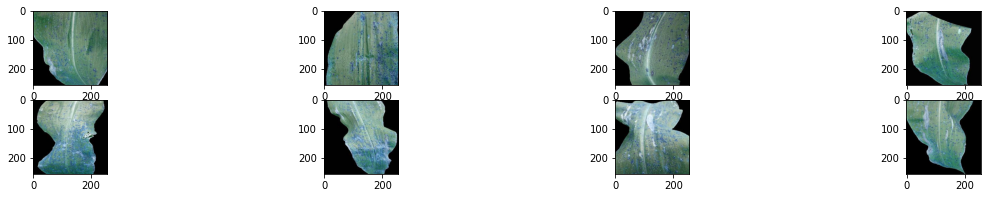

In [ ]:
img_dir="/content/drive/MyDrive/Colab Notebooks/maize/train/Common_rust_"

all_files=os.listdir(img_dir)
data_path = [os.path.join(img_dir + "/" + i) for i in all_files]
k=0
for i in data_path:
  k=k+1
  plt.subplot(2,4,k)
  img = cv2.imread(i)

  plt.imshow(img)
plt.show()

In [ ]:
size = 256

In [ ]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img[:,:,2]

def bgr_lab(rgb_img):
    img_lab = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2LAB)
    return img_lab

In [ ]:

# image segmentation

# for extraction of green and brown color

def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([20,0,20])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(hsv_img, hsv_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(hsv_img, hsv_img, mask=final_mask)
    return final_result
    #return disease_result

In [ ]:

# image segmentation

# for extraction of green and brown color
def img_segmentation(rgb_img,lab_img):
    lower_green = np.array([10,0,10])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(lab_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(lab_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(lab_img, lab_img, mask=final_mask)
    return final_result
    #return disease_result

In [ ]:
# HSV Color Space

H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]

L = img_lab[:, :, 0]
a = img_lab[:, :, 1]
b = img_lab[:, :, 2]

def k_means(image):
  # K-means clustering in opencv
 pixel_vals = L.flatten()
 pixel_vals = np.float32(pixel_vals)
 criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Since we are interested in only actual leaf pixels, we choose 2 clusters
# one cluster for actual leaf pixels and other for unwanted background pixels.
 K = 2
 retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 centers = np.uint8(centers)
 segmented_data = centers[labels.flatten()]
 segmented_image = segmented_data.reshape((L.shape))
 pixel_labels = labels.reshape(img_lab.shape[0], img_lab.shape[1])

 pixel_labels = np.uint8(pixel_labels)
 ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)

 indices = []
 for i in range(1, ret):
     row, col = np.where(components==i)
     indices.append(max(len(row), len(col)))
 component = np.argmax(np.array(indices))
 main_component = component+1   #indexing starts from 0, so we increment by 1 to get actual component index
# creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
# 1 for actual leaf pixels and 0 for other pixels
 mask = np.where(components==main_component, 1, 0)
 B = image[:, :, 0]
 G = image[:, :, 1]
 R = image[:, :, 2]
# Extract only masked pixels
 r = R*mask
 g = G*mask
 b = B*mask
 final_img = np.dstack((r, g, b))
 return(final_img)

NameError: ignored

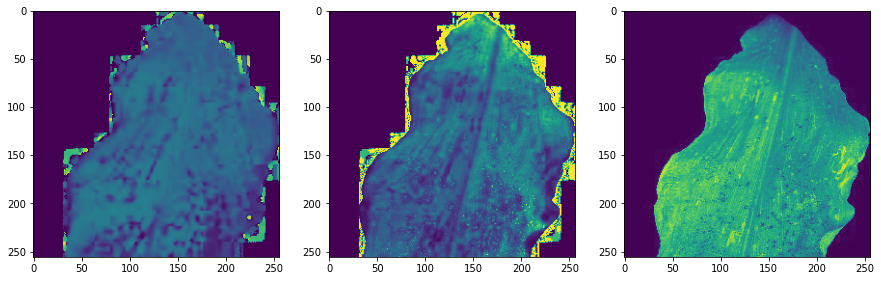

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(H)
ax[1].imshow(S)
ax[2].imshow(V)

In [ ]:
train_images = []
train_labels = []

for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/maize/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        print(img_path)
        img1 = cv2.imread(img_path)
        img1 = cv2.resize(img1, (size, size))
        img_rgb = rgb_bgr(img1)
        img_hsv = bgr_hsv(img_rgb)
        img_seg = img_segmentation(img_rgb, img_hsv)
        #img_seg = k_means(img1)
        #plt.imshow(img_seg)
        #plt.show()
        img_seg = img_seg.reshape((-1, 3))

        train_images.append(img_seg)
        train_labels.append(label)

/content/drive/MyDrive/Colab Notebooks/maize/train/healthy
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/201141a7-69a3-40b2-90fd-da538cf10ffa___R.S_HL 7908 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/21f7da6b-c22e-4f1a-9a22-39aaaa6cc38a___R.S_HL 5551 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/18fb5907-fb42-407e-8ad7-baee0d01f60b___R.S_HL 8168 copy 2.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/15e8fdce-816e-4a57-ae54-10ba5638fb0a___R.S_HL 0618 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1e79939c-ad56-48fe-b742-bee115562523___R.S_HL 8060 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1a95abb5-1e21-47ce-a1d9-fc9d235a2da6___R.S_HL 5537 copy 3.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1786c452-6e31-43f3-b3d7-0ca81fe4434f___R.S_HL 7959 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/154291fb-97ed-47ea-8323-ac0c099f54ec___R.S_HL

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#le.fit(test_labels)
#test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
le.fit(train_labels1)
train_labels_encoded1 = le.transform(train_labels1)

In [ ]:
#Using train-test-split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size = 0.3, random_state = 42)

In [ ]:
#Using train-test-split
from sklearn.model_selection import train_test_split
x_train1,x_test1, y_train1, y_test1 = train_test_split(train_images1, train_labels_encoded1, test_size = 0.2, random_state = 42)

In [ ]:

#Normalize pixel values
x_train1, x_test1 = x_train1/255.0, x_test1/255.0

In [ ]:
# FEATURE EXTRACTOR function
from skimage.feature import greycomatrix, greycoprops
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_ext(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file
        #print(image)

        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        img = dataset[image, :,:]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME

         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(img, [3], [0])
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(img, [5], [0])
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3


        GLCM4 = greycomatrix(img, [0], [np.pi/4])
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4

        GLCM5 = greycomatrix(img, [0], [np.pi/2])
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5

        GLCM7 = greycomatrix(img, [0], [3*np.pi/4])
        GLCM_Energy7 = greycoprops(GLCM7, 'energy')[0]
        df['Energy7'] = GLCM_Energy7
        GLCM_corr7 = greycoprops(GLCM7, 'correlation')[0]
        df['Corr7'] = GLCM_corr7
        GLCM_diss7 = greycoprops(GLCM7, 'dissimilarity')[0]
        df['Diss_sim7'] = GLCM_diss
        GLCM_hom7 = greycoprops(GLCM7, 'homogeneity')[0]
        df['Homogen7'] = GLCM_hom7
        GLCM_contr7 = greycoprops(GLCM7, 'contrast')[0]
        df['Contrast7'] = GLCM_contr7

        #Shanon Entropy
        entropy = shannon_entropy(img)
        df['Entropy'] = entropy



        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset

In [ ]:
features = feature_ext(x_train)

In [ ]:
features = np.expand_dims(features, axis=0)
x_train_rf = np.reshape(features,(x_train.shape[0], -1))

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
model.fit(x_train_rf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier()
KNN_model.fit(x_train_rf, y_train)

KNeighborsClassifier()

In [ ]:
test_features = feature_ext(x_test)
test_features = np.expand_dims(test_features, axis=0)

test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

In [ ]:
test_prediction_SVM = SVM_model.predict(test_for_RF)

In [ ]:
test_prediction_RF = model.predict(test_for_RF)


In [ ]:
test_prediction_KNN = KNN_model.predict(test_for_RF)

In [ ]:
#test_prediction_RF = le.inverse_transform(test_prediction_RF)

In [ ]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train_rf, y_train)

SVC(decision_function_shape='ovo')

In [ ]:
from sklearn import metrics
print ("RF Accuracy = ", metrics.accuracy_score(y_test, test_prediction_RF))
print ("SVM Accuracy = ", metrics.accuracy_score(y_test, test_prediction_SVM))
print ("KNN Accuracy = ", metrics.accuracy_score(y_test, test_prediction_KNN))

RF Accuracy =  0.7621107266435986
SVM Accuracy =  0.6072664359861591
KNN Accuracy =  0.583044982698962


[[ 31  44  78   0]
 [ 16 293  32   0]
 [ 26  76 185   3]
 [  0   0   0 372]]


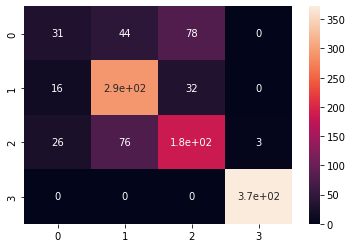

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_prediction_RF)
print(cm)
sns.heatmap(cm, annot=True)

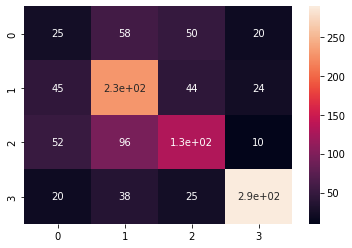

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_prediction_KNN)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_test,test_prediction_KNN))

              precision    recall  f1-score   support

           0       0.18      0.16      0.17       153
           1       0.54      0.67      0.60       341
           2       0.53      0.46      0.49       290
           3       0.84      0.78      0.81       372

    accuracy                           0.58      1156
   macro avg       0.52      0.52      0.52      1156
weighted avg       0.59      0.58      0.58      1156



In [ ]:
#Using LGBM model to classify
import lightgbm as lgb
 #Class names for LGBM start at 0 so reassigning labels from 1,2,3,4 to 0,1,2,3
d_train = lgb.Dataset(x_train_rf, label=y_train)

lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':4}  #no.of unique values in the target class not inclusive of the end value


lgb_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates

In [ ]:
lgbm_predict = lgb_model.predict(test_for_RF)
lgbm_predict = np.argmax(lgbm_predict, axis=1)

In [ ]:
print("lgbm Accuracy : ", metrics.accuracy_score(y_test, lgbm_predict))

lgbm Accuracy :  0.7837370242214533


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
params = [{'kernel': ['rbf'],
               'gamma': [1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]

In [ ]:
Tuned_svm.best_params_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_rf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=50,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
import random
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [ ]:
import time
grid = RandomizedSearchCV(lgb_model, param_grid)
start = time.time()
grid.fit(x_train_rf, y_train)
# evaluate the best randomized searched model on the testing
# data
print("[INFO] randomized search took {:.2f} seconds".format(
	time.time() - start))
acc = grid.score(y_test, lgbm_predict)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] randomized search best parameters: {}".format(
	grid.best_params_))

TypeError: ignored

In [ ]:
#Using train-test-split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(test_images, test_labels_encoded, test_size = 0.2, random_state = 42)

In [ ]:
test_features = feature_ext(x_train)

In [ ]:
test_features = np.expand_dims(test_features, axis=0)

test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

In [ ]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(test_for_RF, y_train)

ValueError: ignored

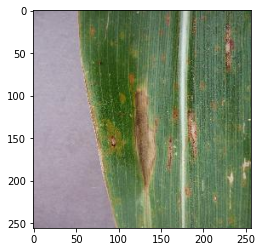

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/maize/train/Northern_Leaf_Blight/bfe59dc5-c1fd-4fb0-8c6f-ed9b1d9da11b___RS_NLB 0786.JPG")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
plt.imshow(rgb_img)
plt.show()

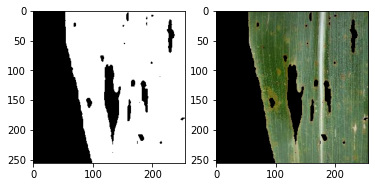

In [ ]:
 lower_green = np.array([25,0,20])
upper_green = np.array([100,255,255])
mask = cv2.inRange(hsv_img, lower_green, upper_green)
result = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

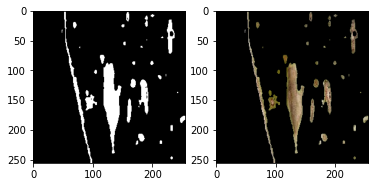

In [ ]:
lower_brown = np.array([10,0,10])
upper_brown = np.array([30,255,255])
disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
plt.subplot(1, 2, 1)
plt.imshow(disease_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(disease_result)
plt.show()

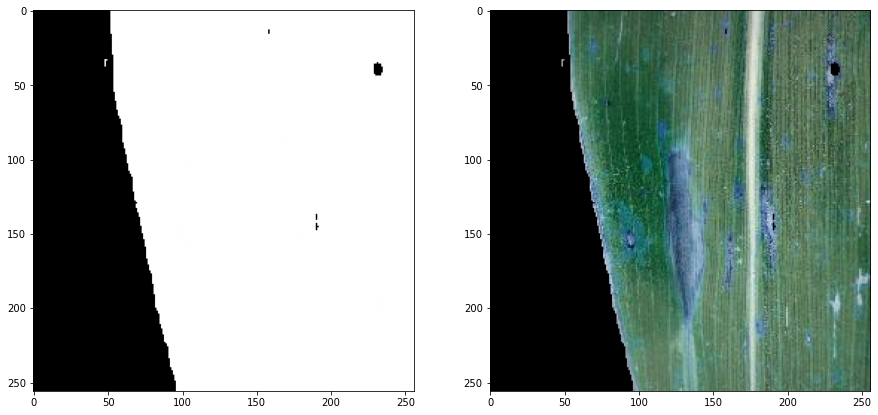

In [ ]:
final_mask = mask + disease_mask
final_result = cv2.bitwise_and(img, img, mask=final_mask)
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

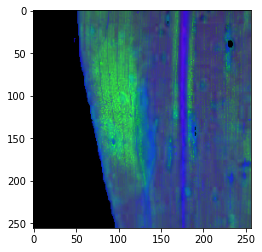

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/maize/train/Northern_Leaf_Blight/bfe59dc5-c1fd-4fb0-8c6f-ed9b1d9da11b___RS_NLB 0786.JPG")
img_rgb = rgb_bgr(img1)
img_hsv = bgr_hsv(img_rgb)
img_lab = bgr_lab(img_rgb)
img_seg = img_segmentation(img_rgb, img_hsv)
#img_keans = k_means(img1)
plt.imshow(img_seg)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNN_model,x_train_rf, y_train, cv=5)
scores

array([0.55925926, 0.57513915, 0.567718  , 0.54730983, 0.55844156])

In [ ]:
 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
 blur = cv2.GaussianBlur(gs, (25,25),0)
 ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
 kernel = np.ones((50,50),np.uint8)
 closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

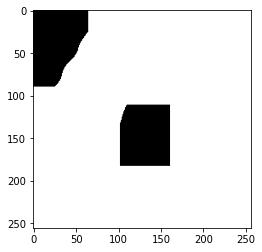

In [ ]:
plt.imshow(closing,cmap='Greys_r')

In [ ]:
 hue = rgb_img[:,:,1]
 ret_otsu,im_bw_otsu = cv2.threshold(hue,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

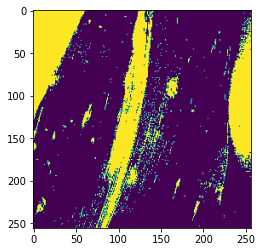

In [ ]:
regions = np.digitize(hue, bins=np.array([ret_otsu]))
plt.imshow(regions)

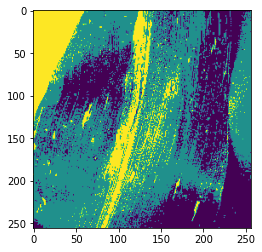

In [ ]:
from skimage.filters import threshold_multiotsu

# Apply multi-Otsu threshold
thresholds = threshold_multiotsu(hue, classes=3)

# Digitize (segment) original image into multiple classes.
#np.digitize assign values 0, 1, 2, 3, ... to pixels in each class.
regions = np.digitize(hue, bins=thresholds)
plt.imshow(regions)

segm1 = (regions == 0)
segm2 = (regions == 1)
segm3 = (regions == 2)


In [ ]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [ ]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)


        # Running Function Bit By Bit

        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors

        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)

        # Concatenate

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])



        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

In [ ]:
train_images1 = []
train_labels1 = []

for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/maize/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        print(img_path)
        img1 = cv2.imread(img_path)
        img1 = cv2.resize(img1, (size, size))
        img_rgb = rgb_bgr(img1)
        img_hsv = bgr_hsv(img_rgb)
        img_seg = img_segmentation(img_rgb, img_hsv)
        #plt.imshow(img_seg)
        #plt.show()
        #img_seg = img_seg.reshape((-1, 3))

        train_images1.append(img_seg)
        train_labels1.append(label)

/content/drive/MyDrive/Colab Notebooks/maize/train/healthy
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/201141a7-69a3-40b2-90fd-da538cf10ffa___R.S_HL 7908 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/21f7da6b-c22e-4f1a-9a22-39aaaa6cc38a___R.S_HL 5551 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/18fb5907-fb42-407e-8ad7-baee0d01f60b___R.S_HL 8168 copy 2.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/15e8fdce-816e-4a57-ae54-10ba5638fb0a___R.S_HL 0618 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1e79939c-ad56-48fe-b742-bee115562523___R.S_HL 8060 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1a95abb5-1e21-47ce-a1d9-fc9d235a2da6___R.S_HL 5537 copy 3.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/1786c452-6e31-43f3-b3d7-0ca81fe4434f___R.S_HL 7959 copy.jpg
/content/drive/MyDrive/Colab Notebooks/maize/train/healthy/154291fb-97ed-47ea-8323-ac0c099f54ec___R.S_HL

In [ ]:
train_images1 = np.array(train_images1)
train_labels1 = np.array(train_labels1)

In [ ]:
def feature_extractor(dataset):
    x_train1 = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train1):  #iterate through each file
        #print(image)

        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        input_img = x_train1[image, :,:,:]
        img = input_img

        df['fv_histogram']  = fd_histogram(img)
        image_dataset = image_dataset.append(df)

    return image_dataset

In [ ]:
train_images.shape

(3852, 65536, 3)

In [ ]:
from skimage.filters import sobel
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file
        #print(image)

        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        input_img = x_train[image, :,:,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc.

         # FEATURE 1 - Pixel values
        red_channel = img[:,:,0]

        green_channel = img[:,:,1]
        blue_channel = img[:,:,2]
        blue_channel[blue_channel == 255] = 0
        green_channel[green_channel == 255] = 0
        red_channel[red_channel == 255] = 0

        df['red_mean'] = np.mean(red_channel)

        df['green_mean'] = np.mean(green_channel)
        df['blue_mean'] = np.mean(blue_channel)

        df['red_std'] = np.std(red_channel)
        df['green_std'] = np.std(green_channel)
        df['blue_std'] = np.std(blue_channel)
        #Add more filters as needed

        vector = [red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
                  contrast,correlation,inverse_diff_moments,entropy
                 ]

        df_temp = pd.DataFrame([vector],columns=names)
        df = df.append(df_temp)
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset
####################################################################


In [ ]:
#Extract features from training images
image_features = feature_extractor(x_train1)

Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], Name: red_mean, dtype: float64)
Series([], 

KeyboardInterrupt: ignored

In [ ]:
image_features.head(8)

,red_mean,green_mean,blue_mean,red_std,green_std,blue_std


In [ ]:
        img = rgb_img
        red_channel = img[:,:,0]
        green_channel = img[:,:,1]
        blue_channel = img[:,:,2]
        blue_channel[blue_channel == 255] = 0
        green_channel[green_channel == 255] = 0
        red_channel[red_channel == 255] = 0

        red_mean = np.mean(red_channel)
        green_mean = np.mean(green_channel)
        blue_mean = np.mean(blue_channel)

        red_std = np.std(red_channel)
        green_std = np.std(green_channel)
        blue_std = np.std(blue_channel)

In [ ]:
red_mean

92.66392517089844

The prediction for this image is:  ['/content/drive/MyDrive/Colab Notebooks/maize/train/Northern_Leaf_Blight']
The actual label for this image is:  /content/drive/MyDrive/Colab Notebooks/maize/train/Northern_Leaf_Blight


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


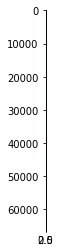

In [ ]:
#Check results on a few random images
import random
n=random.randint(0, x_train.shape[0]-1) #Select the index of image to be loaded for testing
img = x_train[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_ext(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = lgb_model.predict(input_img_for_RF)
img_prediction=np.argmax(img_prediction, axis=1)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", train_labels[n])